In [17]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [18]:
with open('./data/imdb_data.json') as f:
    all_imdb = json.load(f)

len(all_imdb)

80134

In [19]:
# Load in the previously cleaned dataset
init_df = pd.read_csv('./data/post_vis_cleaned_data.csv', index_col=0)

In [20]:
# Make a new dataset from the json we loaded in
imdb_df = pd.DataFrame.from_dict(all_imdb)
imdb_df = imdb_df.T

imdb_df = imdb_df.rename_axis('imdb_id').reset_index()
imdb_df = imdb_df.rename({"rating": "imdb_rating", "budget": "imdb_budget", "revenue": "imdb_revenue"}, axis=1)
imdb_df.head()

,imdb_id,imdb_rating,imdb_budget,imdb_revenue
0,tt0095733,5.9,,
1,tt0825671,8.1,"€100,000 (estimated)","$1,871"
2,tt0266543,8.2,"$94,000,000 (estimated)","$941,637,960"
3,tt0169547,8.4,"$15,000,000 (estimated)","$356,296,601"
4,tt0168629,7.9,"$12,800,000 (estimated)","$40,061,153"


In [21]:
# Merge the new IMDB columns into a final df
df = init_df.merge(imdb_df, on='imdb_id', how='outer')
df['imdb_budget'] = df['imdb_budget'].astype(str)
df['imdb_revenue'] = df['imdb_revenue'].astype(str)

In [22]:
def get_curr(x):
    cur_string = ""
    for i in x:
        if not i.isdigit():
            cur_string += i
    return cur_string

def replace_curr(x):
    cur_string = ""
    for i in x:
        if i.isdigit():
            cur_string += i
    return cur_string

def convert_curr(x):
    if x == '€':
        return 'EUR'
    elif x == '$':
        return 'USD'
    elif x == '£':
        return 'GBP'
    elif x == 'A$':
        return 'AUD'
    elif x == 'CA$':
        return 'CAD'
    elif x == 'NZ$':
        return 'NZD'
    elif x == '₹':
        return 'INR'
    elif x == 'CN¥' or x == '¥':
        return 'CNY'
    elif x == '₱':
        return 'PHP'
    elif x == '₪':
        return 'ILS'
    elif x == 'MX$':
        return 'MXN'
    elif x == 'R$':
        return 'BRL'
    elif x == '₩':
        return 'KRW'
    elif x == 'NT$':
        return 'TWD'
    elif x == 'HK$':
        return 'HKD'
    elif x == 'EC$':
        return 'XCD'
    else:
        return x

# Remove any empty characters or (estimated) from the revenue and budget
df['imdb_budget'] = df['imdb_budget'].map(lambda x: x.replace('(estimated)', ''))
df['imdb_budget'] = df['imdb_budget'].map(lambda x: x.replace(',', ''))
df['imdb_budget'] = df['imdb_budget'].map(lambda x: x.replace(' ', ''))
df['imdb_budget'] = df['imdb_budget'].map(lambda x: x.replace(u'\xa0', ''))

df['imdb_revenue'] = df['imdb_revenue'].map(lambda x: x.replace('(estimated)', ''))
df['imdb_revenue'] = df['imdb_revenue'].map(lambda x: x.replace(',', ''))
df['imdb_revenue'] = df['imdb_revenue'].map(lambda x: x.replace(' ', ''))
df['imdb_revenue'] = df['imdb_revenue'].map(lambda x: x.replace(u'\xa0', ''))

# Get the currency code for each movie
df['budget_currency'] = df['imdb_budget'].map(get_curr)
df['revenue_currency'] = df['imdb_revenue'].map(get_curr)

df['imdb_budget'] = df['imdb_budget'].map(replace_curr)
df['imdb_revenue'] = df['imdb_revenue'].map(replace_curr)

# Convert the currency code to a useable format
df['budget_currency'] = df['budget_currency'].map(convert_curr)
df['revenue_currency'] = df['revenue_currency'].map(convert_curr)

In [23]:
curr_df = pd.read_csv('./data/currency_data.csv')
curr_df.head()

indexEuro = curr_df[(curr_df['CURRENCY'] == 'EUR') & (curr_df['Reference area'] != 'Euro area')].index
curr_df.drop(indexEuro, inplace=True)
# BDT, BEF, BGL, DEM, DOP, EEK, EGP, ESP, FIM, FRF, GRD, ITL, JMD, JOD, MMK, NAD, NGN, NLG, PTE, ROL, RUR, SDD, TRL, UGX, VEB, XCD missing

In [24]:
date_format_str = '%Y-%m-%d'

# Convert the imdb_budget column to a numeric type
df['imdb_budget'] = pd.to_numeric(df['imdb_budget'], errors='coerce')
df['imdb_revenue'] = pd.to_numeric(df['imdb_revenue'], errors='coerce')

# Create a new column to store the converted budget amounts
df['converted_budget'] = pd.NA
df['converted_revenue'] = pd.NA

# Loop through each row and extract the budget amount and currency code
for index, row in df.iterrows():
    budget = row['imdb_budget']
    budget_currency_code = row['budget_currency']
    revenue = row['imdb_revenue']
    revenue_currency_code = row['revenue_currency']

    # Look up the conversion rates in the curr_df dataframe
    # and multiply the budget amount by the conversion rate to get the converted budget
    date_str = row['release_date']
    if (not pd.isna(date_str)) and (date_str < "1949-01-03"):
        date_str = "1949-01-03"
    if budget_currency_code == 'USD':
        df.at[index, 'converted_budget'] = budget
    else:
        try:
            seek_date = date_str
            budget_conversion_rate = curr_df.loc[curr_df['CURRENCY'] == budget_currency_code, seek_date]
            forward = True
            # If the current date is missing, keep going forward in time until we find one that works
            while pd.isna(budget_conversion_rate.values[0]):
                datetime_obj = datetime.datetime.strptime(seek_date, date_format_str)
                if forward:
                    datetime_obj = datetime_obj + datetime.timedelta(days=1)
                else:
                    datetime_obj = datetime_obj - datetime.timedelta(days=1)
                seek_date = datetime_obj.strftime(date_format_str)
                if seek_date == '2023-02-15':
                    # This allows us to go backward in time if we didn't find anything forward
                    seek_date = date_str
                    forward = False
                elif seek_date == "1949-01-02":
                    # Just break if we've tried both
                    break
                budget_conversion_rate = curr_df.loc[curr_df['CURRENCY'] == budget_currency_code, seek_date]
            budget_conversion_rate = (1.0 / budget_conversion_rate.values[0])
            converted_budget = budget * budget_conversion_rate
            df.at[index, 'converted_budget'] = converted_budget
        except:
            pass
    if revenue_currency_code == 'USD':
        df.at[index, 'converted_revenue'] = revenue
    else:
        try:
            seek_date = date_str
            revenue_conversion_rate = curr_df.loc[curr_df['CURRENCY'] == revenue_currency_code, seek_date]
            forward = True
            # If the current date is missing, keep going forward in time until we find one that works
            while pd.isna(revenue_conversion_rate.values[0]):
                datetime_obj = datetime.datetime.strptime(seek_date, date_format_str)
                if forward:
                    datetime_obj = datetime_obj + datetime.timedelta(days=1)
                else:
                    datetime_obj = datetime_obj - datetime.timedelta(days=1)
                seek_date = datetime_obj.strftime(date_format_str)
                if seek_date == '2023-02-15':
                    # This allows us to go backward in time if we didn't find anything forward
                    seek_date = date_str
                    forward = False
                elif seek_date == "1949-01-02":
                    # Just break if we've tried both
                    break
                revenue_conversion_rate = curr_df.loc[curr_df['CURRENCY'] == revenue_currency_code, seek_date]
            revenue_conversion_rate = (1.0 / revenue_conversion_rate.values[0])
            converted_revenue = revenue * revenue_conversion_rate
            df.at[index, 'converted_revenue'] = converted_revenue
        except:
            pass

In [25]:
df[df['imdb_id'] == 'tt0018455']

,budget,genres,id,imdb_id,original_title,overview,popularity,poster_path,release_date,revenue,...,title_length,num_languages,num_genres,imdb_rating,imdb_budget,imdb_revenue,budget_currency,revenue_currency,converted_budget,converted_revenue
171,0.0,"['Drama', 'Romance']",631,tt0018455,Sunrise: A Song of Two Humans,A married farmer falls under the spell of a sl...,8.431,/oj8ZW8jKXBSs8F1e5iWsTUeXSJW.jpg,1927-11-04,0,...,29,1,2,8.1,200000.0,121107.0,USD,USD,200000.0,121107.0


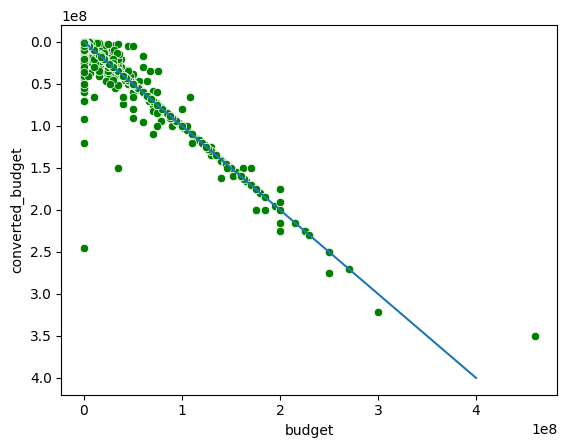

In [26]:
# plt.figure()
# plt.plot([0, 0], [40, 40], linewidth=2)
# plt.show()
sns.scatterplot(data=df, x='budget', y='converted_budget', color='green')
plt.plot([400000000, 0], [400000000, 0])


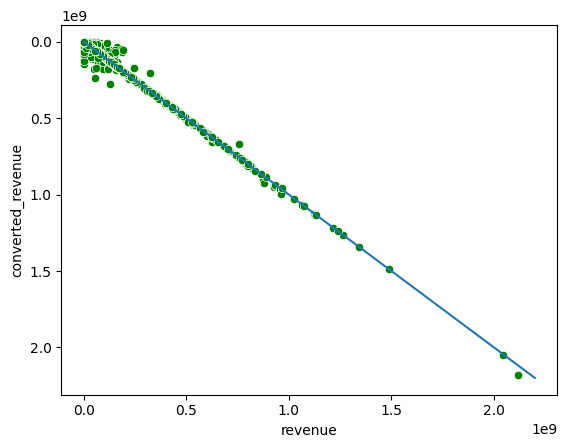

In [27]:
sns.scatterplot(data=df, x='revenue', y='converted_revenue', color='green')
plt.plot([2200000000, 0], [2200000000, 0])

In [28]:
# Set the combined budget to the average of tmdb and imdb data
df['combined_budget'] = df[['converted_budget', 'budget']].mean(axis=1)
df.loc[(df['budget'] == 0) & (df['converted_budget']), 'combined_budget'] = df['converted_budget']

# Do the same with revenue
df['combined_revenue'] = df[['converted_revenue', 'revenue']].mean(axis=1)
df.loc[(df['revenue'] == 0) & (df['converted_revenue']), 'combined_revenue'] = df['converted_revenue']

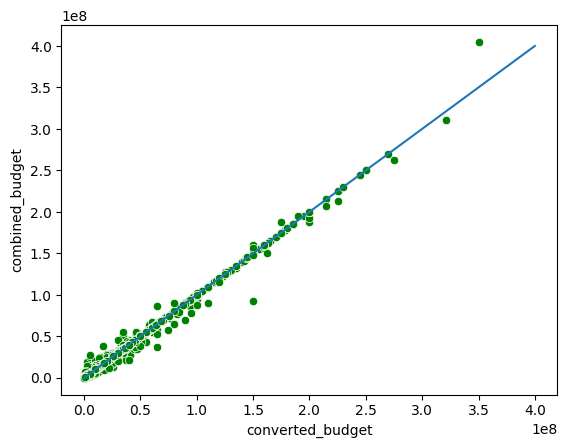

In [29]:
sns.scatterplot(data=df, x='converted_budget', y='combined_budget', color='green')
plt.plot([400000000, 0], [400000000, 0])

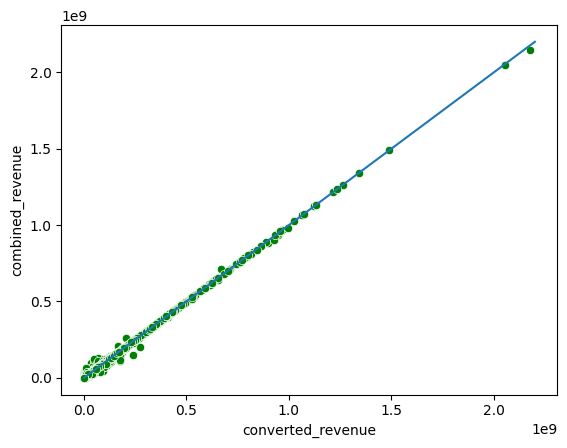

In [30]:
sns.scatterplot(data=df, x='converted_revenue', y='combined_revenue', color='green')
plt.plot([2200000000, 0], [2200000000, 0])

In [31]:
df.count()

budget               114510
genres               114510
id                   114510
imdb_id               80134
original_title       114509
overview             112281
popularity           114510
poster_path           82690
release_date         107336
revenue              114510
runtime              114510
spoken_languages     114510
tagline               28002
title                114509
vote_average         114510
vote_count           114510
log_popularity       114510
title_length         114510
num_languages        114510
num_genres           114510
imdb_rating           80134
imdb_budget           16012
imdb_revenue           7816
budget_currency      114510
revenue_currency     114510
converted_budget      15723
converted_revenue      7816
combined_budget      114510
combined_revenue     114510
dtype: int64

In [32]:
df.to_csv('./data/imdb_cleaned_data.csv')